In [194]:
import sys, joblib
sys.path.append('../../..')
from grid import *
import scipy.special
import matplotlib.pyplot as plt
import analyze_tools
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
r = joblib.load('output.bin')
result = r['result']
train = r['train']

# Demo task rendering

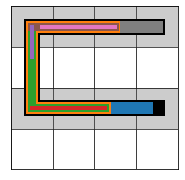

In [391]:
task, tf = next(analyze_tools.iter_frontiers(train, result))
s = tf.execute_best(trace=True)['state']
analyze_tools.plot(tf)

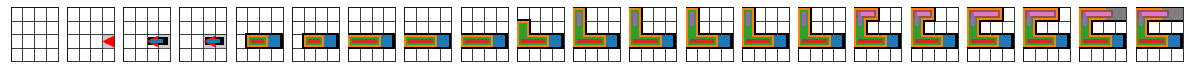

In [392]:
analyze_tools.plot_trace(tf.task.start, s.history)
analyze_tools.plot_trace(tf.task.start, s.history, animate=True)

## Demo of simple case of stack trace rendering

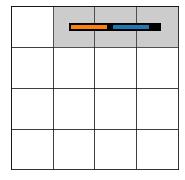

In [393]:
p =  Program.parse('''
(lambda (#(lambda (grid_move_no_mark (grid_mark_current_location $0))) (#(lambda (grid_move_no_mark (grid_mark_current_location $0))) $0)))
''')
s = analyze_tools.execute_grid(p, np.zeros((4, 4)), (3, 3), trace=True)
analyze_tools.plot(np.zeros((4, 4)), s.grid, s.history)

# showing all solutions

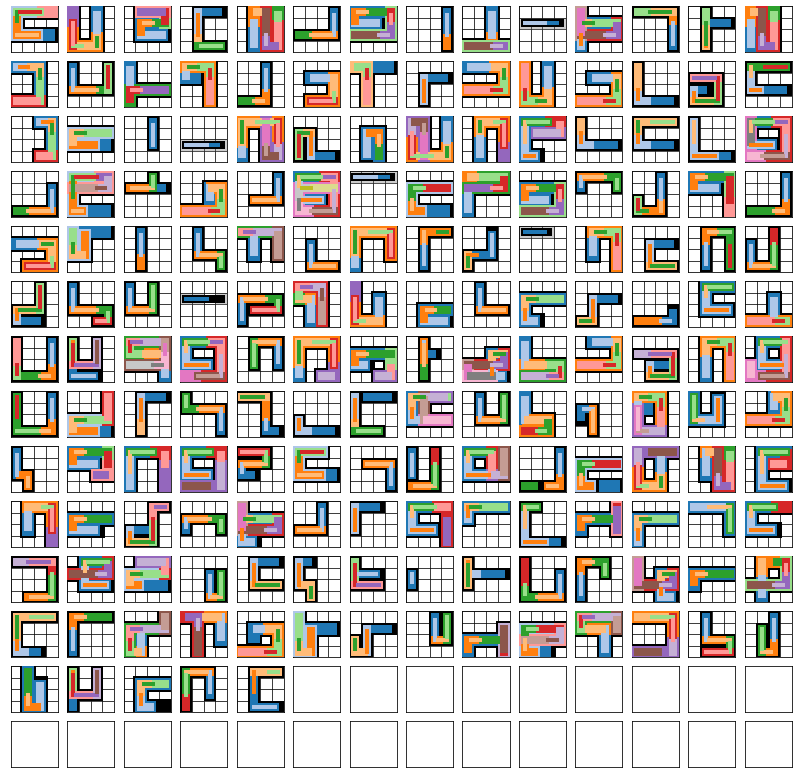

In [402]:
f, axes = plt.subplots(14, 14, figsize=(14, 14))
axes = axes.flatten().tolist()
for ax in axes: ax.set(xticks=[], yticks=[])

for task, tf in analyze_tools.iter_frontiers(train, result):
    if not tf.is_solved():
        continue
    analyze_tools.plot(tf, ax=axes.pop(0))
    if not axes:
        break


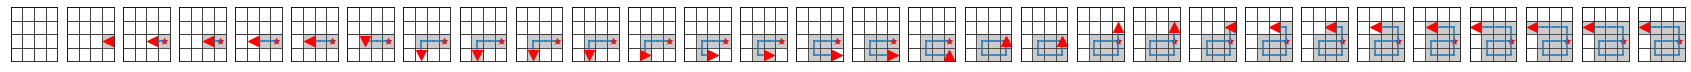

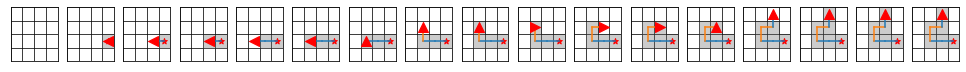

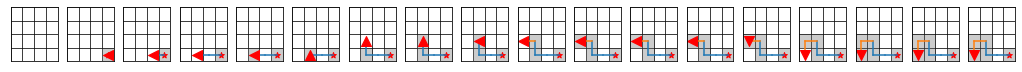

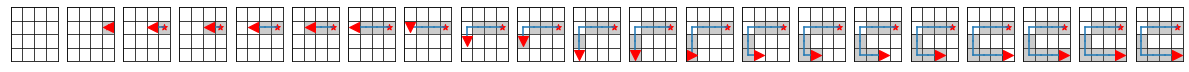

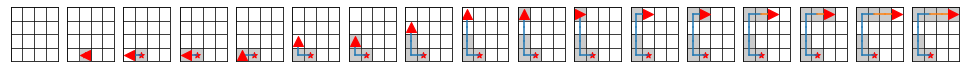

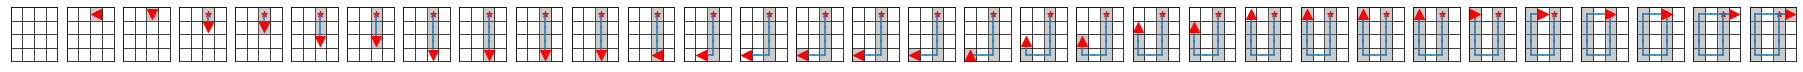

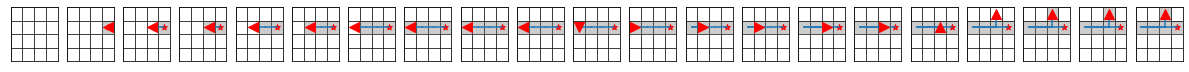

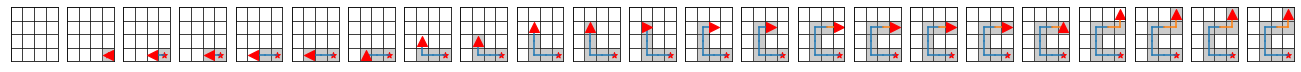

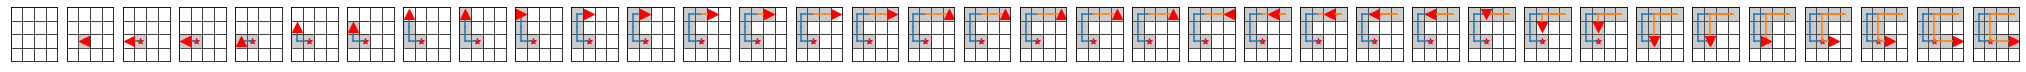

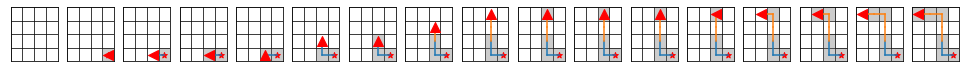

In [267]:
weights = []
for task in train:
    es = result.frontiersOverTime[task][-1].entries
    if es:
        fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
        weights.append(-fe.logPrior)
    else:
        weights.append(-float('inf'))

for taskidx in np.random.choice(len(train), p=scipy.special.softmax(weights), replace=False, size=min(10, len(train))):
    task = train[taskidx]
    es = result.frontiersOverTime[task][-1].entries
    if not es:
        continue
    tf = analyze_tools.TaskFrontier(task, es)
    analyze_tools.plot_trace(tf)
    plt.show()


# dreams

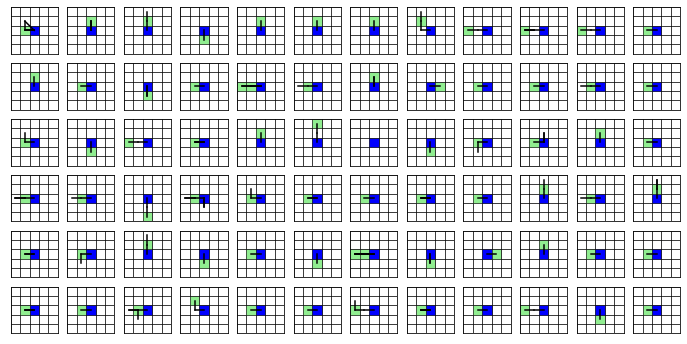

In [111]:
def dream_grammar(g):
    f, axes = plt.subplots(6, 12, figsize=(12, 6))
    axes = axes.flatten().tolist()

    #trivial = dreamcoder.program.Abstraction(dreamcoder.program.Index(0))
    programs = []

    for ax in axes:
        start, location = np.array([[0]*5]*5), (2, 2)
        start[location] = 1
        for _ in range(20):
            p = g.sample(g.continuationType)
            '''
            if p != trivial:
                break
            '''
            s = executeGrid(p, GridState(start, location, history=[]))
            if s is None:
                continue
            if not np.all(start==s.grid):
                break
        showtask(start, s.grid, s.history, ax=ax)
        programs.append(p)

dream_grammar(result.grammars[0])

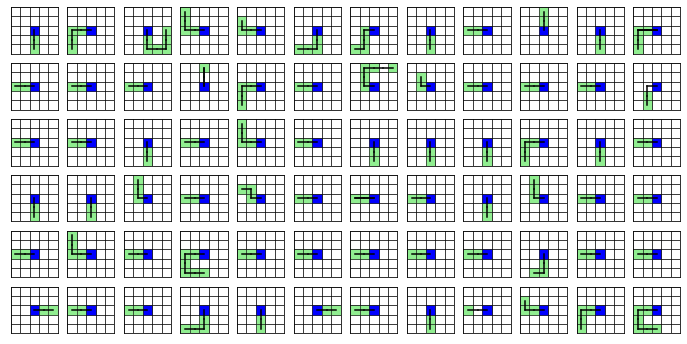

In [112]:
dream_grammar(result.grammars[1])

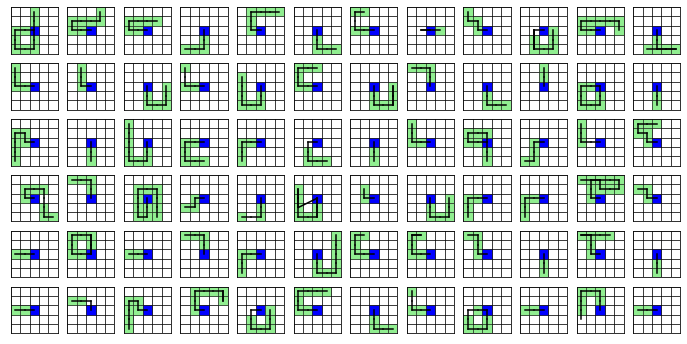

In [113]:
dream_grammar(result.grammars[2])

# library

In [114]:
def simplest_sorted_library(library):
    return sorted(
        library,
        # First we sort by # of references to other library items
        # then we sort by program length
        key=lambda fn: (len(str(fn).split('#')), len(str(fn))))

def distinct(idx, grammars):
    #prev = {p for g in grammars[:idx] for p in g.primitives}
    prev = {p for p in grammars[0].primitives}
    distinct = set(grammars[idx].primitives) - prev
    return simplest_sorted_library(distinct)

distinct(2, result.grammars)

[#(lambda (grid_move_no_mark (grid_mark_current_location $0))),
 #(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))),
 #(lambda (grid_left (#(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))) $0))),
 #(lambda (grid_move_no_mark (grid_mark_current_location (grid_right (#(lambda (grid_move_no_mark (grid_mark_current_location $0))) $0))))),
 #(lambda (grid_right (#(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))) $0))),
 #(lambda (#(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))) (grid_right (grid_move_no_mark (#(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))) $0))))),
 #(lambda (#(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0))))) (grid

In [115]:
def simplify_signature(fn, tint_value):
    '''
    Plugs in a filler int value if the library routine takes them as parameters
    '''
    rewrote = False

    rv = fn
    ret = fn.infer()

    while ret.isArrow():
        arg, ret = ret.arguments

        if arg == tint:
            rewrote = True
            rv = Application(rv, primitives_numbers_only[tint_value-1])
            '''
        elif arg.isArrow(): # this is a complete hack & will only work for grid_cont -> grid_cont
            rewrote = True
            print('arrow arg', arg, 'rv', rv.infer(), rv)
            rv = Application(rv, Abstraction(Index(0)))
            print('rewrote to', rv.infer(), rv)
            '''
        else:
            rv = Application(rv, Index(0))

    if rewrote:
        return Abstraction(rv)
    else:
        return fn


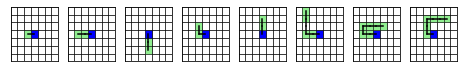

In [116]:
def exec_library_fn(fn):
    orig_fn = fn

    start, location = np.array([[0]*7]*7), (3, 3)
    fn = simplify_signature(fn, location[0])

    has_setloc = 'setloc' in str(fn) # HACK
    if has_setloc:
        # Need to do this to avoid cases where setloc is used incorrectly
        location = (-1, -1)
    else:
        start[location] = 1

    s = executeGrid(fn, GridState(start, location, history=[]))
    # HACK for some library functions, we haven't implemented a way to simplify above, so we
    # wind up with a callaback here.
    if callable(s):
        print('Could not execute library function with signature', orig_fn.infer())
        s = None
    return start, s

def visualize_functions(fns):
    if not fns:
        print('No functions')
        return

    f, axes = plt.subplots(1, len(fns), figsize=(len(fns), 1))

    for fn, ax in zip(fns, axes):
        start, s = exec_library_fn(fn)
        if s is None:
            continue
        showtask(start, s.grid, s.history, ax=ax)

visualize_functions(distinct(2, result.grammars))

library after iteration 1


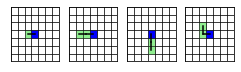

library after iteration 2


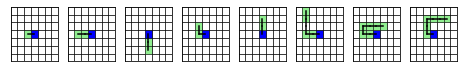

library after iteration 3


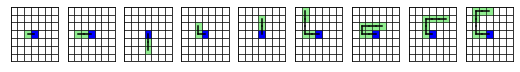

library after iteration 4


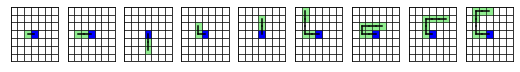

library after iteration 5


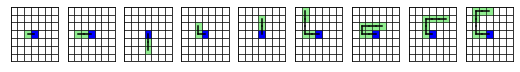

library after iteration 6


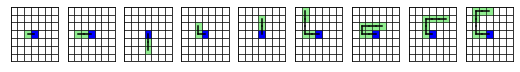

library after iteration 7


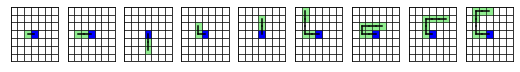

library after iteration 8


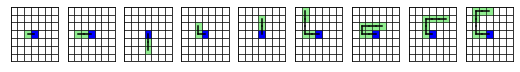

library after iteration 9


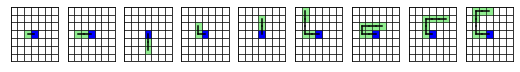

library after iteration 10


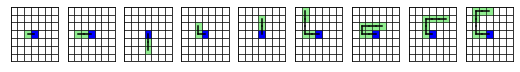

In [117]:
for i in range(1, len(result.grammars)):
    print(f'library after iteration {i}')
    visualize_functions(distinct(i, result.grammars))
    plt.show()

# visualizing traces of final library

In [118]:
items = distinct(2, result.grammars)
prog_desc_depth = simplest_sorted_library(items)
fnnames = {}
compressed = {}

def library_use_by_name(fn):
    strfn = str(fn)
    for subfn in prog_desc_depth[::-1]:
        if subfn in fnnames:
            strfn = strfn.replace(str(subfn), fnnames[subfn])
    return strfn

for i, fn in enumerate(prog_desc_depth):
    compressed[fn] = library_use_by_name(fn)
    fnnames[fn] = f'FN{i}'

In [119]:
def simple_use_of_library(p):
    '''
    Tries to identify cases where our program is just pretty directly using an abstraction.
    '''
    assert type(p) == Abstraction
    assert type(p.body) == Application
    f = p.body
    while type(f) != Invented and type(f) == Application:
        if type(f.x) not in (Primitive, Index):
            return False
        f = f.f
    return True

In [403]:
simple = []
for task in train[:50]:
    es = result.frontiersOverTime[task][-1].entries
    if not es:
        continue
    fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
    p = fe.program
    if simple_use_of_library(p):
        simple.append((task.name, library_use_by_name(p)))
        continue
    print(task, library_use_by_name(p))

print(f'{len(simple)} simple programs: {" ".join(map(str, simple))}')

500_gsp_samples.npy_0 (lambda (FN0 (#(lambda (FN5 (FN4 $0))) (FN0 $0))))
500_gsp_samples.npy_1 (lambda (grid_left (FN2 (#(lambda (FN5 (FN4 $0))) $0))))
500_gsp_samples.npy_2 (lambda (FN2 (FN0 $0)))
500_gsp_samples.npy_3 (lambda (FN2 (#(lambda (FN5 (FN4 $0))) (FN0 $0))))
500_gsp_samples.npy_4 (lambda (FN6 (FN2 (FN2 $0))))
500_gsp_samples.npy_5 (lambda (FN1 (FN2 (FN0 (FN2 $0)))))
500_gsp_samples.npy_6 (lambda (FN4 (FN3 (FN3 (FN6 $0)))))
500_gsp_samples.npy_7 (lambda (FN2 (FN4 (FN0 $0))))
500_gsp_samples.npy_8 (lambda (FN6 (FN7 $0)))
500_gsp_samples.npy_9 (lambda (FN0 (FN1 $0)))
500_gsp_samples.npy_10 (lambda (FN7 (FN6 (FN4 $0))))
500_gsp_samples.npy_11 (lambda (grid_right (FN5 $0)))
500_gsp_samples.npy_12 (lambda (FN2 (FN0 $0)))
500_gsp_samples.npy_13 (lambda (FN2 (FN1 (FN2 (FN7 $0)))))
500_gsp_samples.npy_14 (lambda (#(lambda (FN5 (FN4 $0))) (grid_right (FN3 $0))))
500_gsp_samples.npy_15 (lambda (FN0 (FN1 $0)))
500_gsp_samples.npy_16 (lambda (FN7 (FN6 (FN4 $0))))
500_gsp_samples.npy_17 

FN0 #(lambda (grid_move_no_mark (grid_mark_current_location $0)))


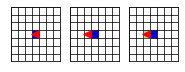

FN1 #(lambda (grid_move_no_mark (grid_mark_current_location (grid_move_no_mark (grid_mark_current_location $0)))))


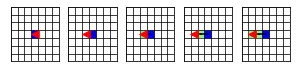

FN2 #(lambda (grid_left (FN1 $0)))


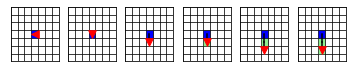

FN3 #(lambda (grid_move_no_mark (grid_mark_current_location (grid_right (FN0 $0)))))


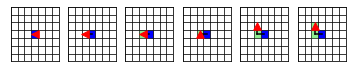

FN4 #(lambda (grid_right (FN1 $0)))


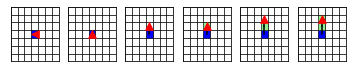

FN5 #(lambda (FN1 (grid_right (grid_move_no_mark (FN1 $0)))))


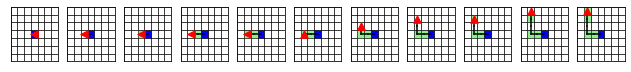

FN6 #(lambda (FN1 (grid_right (FN3 (FN1 $0)))))


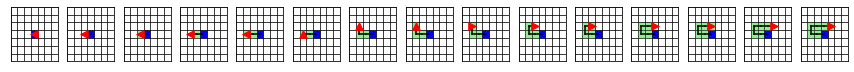

FN7 #(lambda (FN3 (FN3 (FN1 $0))))


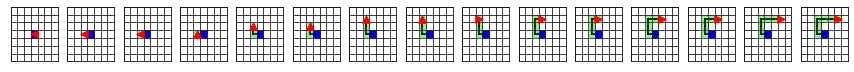

In [121]:
for fn in prog_desc_depth:
    print(fnnames[fn], compressed[fn])
    start, s = exec_library_fn(fn)
    if s is None:
        continue
    show_trace(start, s)
    plt.show()

# counting use of primitives

In [122]:
import collections
def count_primitives(p, *, ct=None):
    if ct is None:
        ct = collections.Counter()
    class Counter(object):
        def invented(self, e): e.body.visit(self)
        def primitive(self, e): ct[e]+=1
        def index(self, e): pass
        def application(self, e): e.f.visit(self); e.x.visit(self)
        def abstraction(self, e): e.body.visit(self)
    p.visit(Counter())
    return ct

def count_prim():
    for fn in [
        #'output/output-taskgrammar-iter4-grammarpen.bin',
        #'output/output-taskgrammar-iter4-grammarpen_setloc-recog.bin',
        'output.bin',
    ]:
        r = joblib.load(fn)
        ct = collections.Counter()
        topct = collections.Counter()
        for task in r['train']:
            es = r['result'].frontiersOverTime[task][-1].entries
            if not es:
                continue
            fe = max(es, key=lambda e: e.logPrior + e.logLikelihood) # get the best
            count_primitives(fe.program, ct=topct)
            for e in es:
                p = e.program
                count_primitives(p, ct=ct)
        print(fn)
        print('best program', topct)
        print('top5', ct)

count_prim()

output.bin
best program Counter({grid_move_no_mark: 3622, grid_mark_current_location: 3424, grid_right: 876, grid_left: 401})
top5 Counter({grid_move_no_mark: 17736, grid_mark_current_location: 16731, grid_right: 4323, grid_left: 1748})


# indenting programs

In [306]:
import collections
def show_indented(p):
    class Indenter(object):
        def __init__(self):
            self.indent = 0
        def invented(self, e): return f'#{e.body.visit(self)}'
        def primitive(self, e): return f'{e.name}'
        def index(self, e): return f'${e.i}'
        def abstraction(self, e): return f'(lambda {e.body.visit(self)})'
        def application(self, e):
            self.indent += 1
            f = e.f.visit(self)
            x = e.x.visit(self)
            ipre = " " * (self.indent-1)
            i = " " * self.indent
            rv = f'''\n{ipre}(\n{i}{f}{x}\n{ipre})'''
            self.indent -= 1
            return rv
    return p.visit(Indenter())

print(show_indented(fe.program))

(lambda 
(
 #(lambda 
 (
  grid_move_no_mark
  (
   grid_mark_current_location
   (
    grid_move_no_mark
    (
     grid_mark_current_location$0
    )
   )
  )
 ))
 (
  #(lambda 
  (
   grid_move_no_mark
   (
    grid_mark_current_location
    (
     grid_right
     (
      #(lambda 
      (
       grid_move_no_mark
       (
        grid_mark_current_location$0
       )
      ))$0
     )
    )
   )
  ))
  (
   #(lambda 
   (
    grid_move_no_mark
    (
     grid_mark_current_location$0
    )
   ))$0
  )
 )
))


# check out recognition model?

In [405]:
r['result'].grammars[0]

In [411]:
cnn = GridCNN(train) # can we get this from result?
x = r['result'].recognitionModel(cnn.featuresOfTask(train[0]))

TypeError: 'NoneType' object is not callable

In [412]:
x.sample(x.continuationType)

AttributeError: 'int' object has no attribute 'sample'

(lambda (grid_right (grid_dopenup (grid_dopenup $0))))


TypeError: taskOfProgram() missing 1 required positional argument: 't'

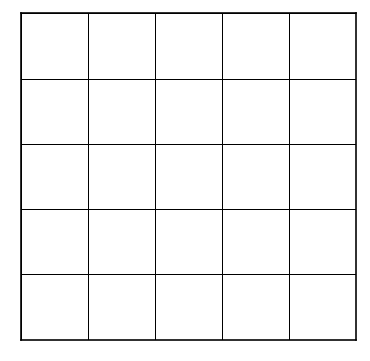

In [349]:
g = r['result'].grammars[0]
p = g.sample(g.continuationType)
start, location = np.array([[0]*5]*5), (2, 2)
if 'setloc' in str(p):
    location = (-1, -1)
s = executeGrid(p, GridState(start, location, history=[]))
showtask(start, s.grid, s.history)

print(p)

cnn = r['result'].recognitionModel.featureExtractor
t = cnn.taskOfProgram(p)
cnn.featuresOfTask(t)